# Predicting Newsletter Subscription in PlaiCraft Using K-NN Classification

### Project Final Report (Group 40)

**Annie Ma 87140554
<br>Kai Shih 52570777
<br>Chuqiao Zhou 69441996
<br>Charlie Gatley 74748740**


## Introduction

### Background
Understanding player behaviour is essential when running a game to maintain the server and increase its audience. Thus, game studios record player data to understand, effectively communicate and retain players. A UBC CS research group led by Professor Frank Wood set up a MineCraft server and recorded players’ in-game actions and other demographic data to further improve their player attraction. The collected data can then be further analyzed to target non-subscribers to their newsletter, and gain an understanding of who is likely to stay in communication with the server project. However, not all players choose to subscribe, even some who are very active on the platform. Finding out which users are more or less likely to subscribe can help developers design better promotional strategies and increase overall subscription rates.

### Question
The question we aimed to answer is <br>**“Can we predict whether or not someone will subscribe to the newsletter based on how much they've played in Plaicraft (`played_hours`) and self-reported Minecraft experience? (`experience`)”**

### Dataset
The datasets given by the CS research group were collected from players engaging with the Plaicraft server over a defined period. 

To explore this question, we used a dataset titled `players.csv`, which contains 196 observations of individual Plaicraft users and 7 variables, which are listed below:
- Player experience level: `experience`
- Subscription status: `subscribe`
- User email: `hashed_Email`
- Total hours played by a user (in hours): `played_hours`
- Player name: `name`
- Player's gender identity: `gender`
- Player age: `age`

| Feature      | Type 
|--------------|-----------|
| experience | Character |
| subscribe | Logical |
| hashed_Email | Character |
| played_hours | Double |
| name | Character |
| gender | Character |
| age | Double |

For the purposes of our project, experience will have to be a **Double** variable and subscribe will have to be a **Factor** variable.

## Method Section

In [1]:
#Loading libraries
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(ggplot2)
library(tidymodels)
library(dplyr)
library(themis)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#Reading data using relative path
set.seed(12)

players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### Modify The Players Data Set
- We modified the data set by selecting only the `subscribe`, `played_hours`, and `experience` columns since they’re the only variables we’re interested in. 
- However, since the experience column was originally a character (chr), we modified it using the `mutate` function and converted it into numeric (dbl) levels. Each experience level is assigned a number: Beginner = 1, Amateur = 2, Regular = 3, Pro = 4, Veteran = 5.
- In order to ensure we can use K-NN classification, our categorical variable `subscribe` must be converted into a factor variable.

In [3]:
#Data wrangling in preparation for classification
set.seed(12)

mod_players <- players |>
                select (subscribe, played_hours, experience) |>
                mutate (subscribe = as_factor(subscribe),
                        experience = recode(experience, Beginner = 1, Amateur = 2, Regular = 3, Pro = 4, Veteran = 5)) 
mod_players

subscribe,played_hours,experience
<fct>,<dbl>,<dbl>
TRUE,30.3,4
TRUE,3.8,5
FALSE,0.0,5
⋮,⋮,⋮
FALSE,0.0,2
FALSE,2.3,2
TRUE,0.2,4


### K-nn Tuning, Unsample & Accuracy Plot
- We used `set.seed(12)` in order to maintain reproducibility.
- In this section, we tune our data using the k-nn classification method and apply the `up_sample` function to balance the weight of the predictor variables
- We performed 5-fold cross-validation and tuned for k, with the number of neighbours ranging from 2 to 100, increasing by one each time.
- In the end, we plotted the accuracy versus the number of neighbours. However, we found that accuracy plot didn’t help much in determining the best value for k.
- The plot didn’t show a clear trend or peak that would guide us to pick one value over the others, so it didn’t provide helpful information for the final model selection.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5175041,5,0.03025870,Preprocessor1_Model01
2,roc_auc,binary,0.5217339,5,0.02833102,Preprocessor1_Model01
3,accuracy,binary,0.4361084,5,0.04112917,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,roc_auc,binary,0.4969968,5,0.04611618,Preprocessor1_Model98
100,accuracy,binary,0.5015928,5,0.06433796,Preprocessor1_Model99
100,roc_auc,binary,0.4894365,5,0.04309054,Preprocessor1_Model99


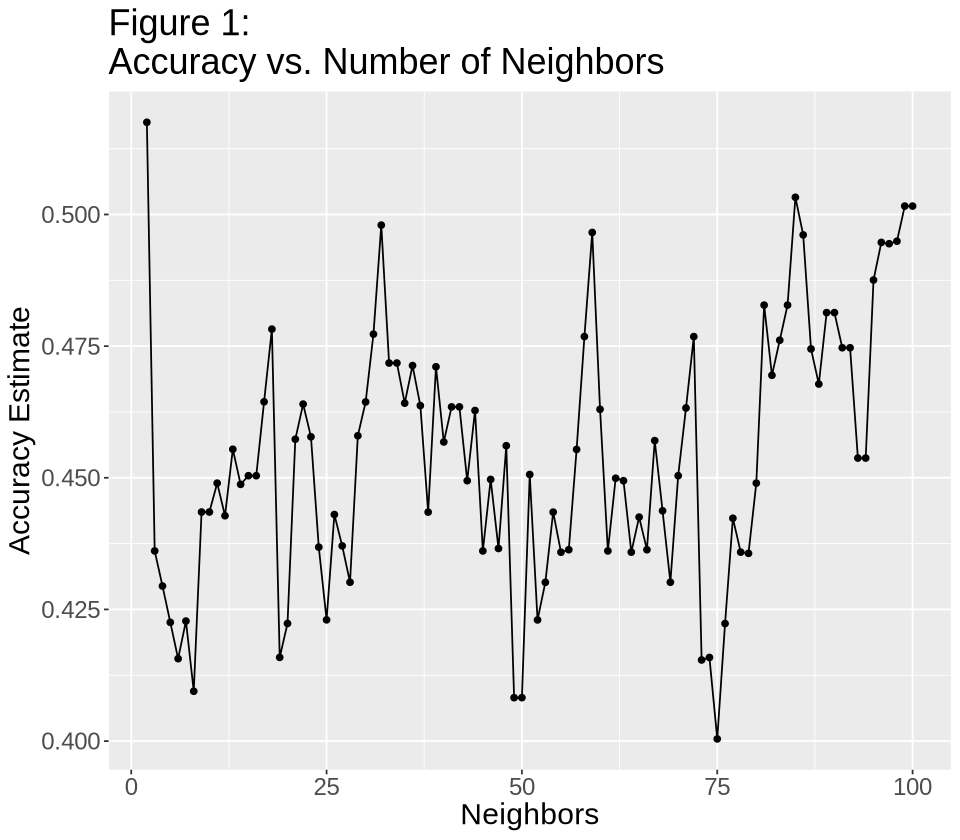

In [4]:
# K-nn Tuning (with cross-validation) + upsampling 
set.seed(12)
players_split <- mod_players |> 
                    initial_split (prop = 0.75, strata = subscribe) 

players_training <- training (players_split)
players_testing <- testing (players_split)

recipe_with_step <- recipe(subscribe ~ ., data = players_training) |>
                        step_center(all_predictors()) |>
                        step_scale(all_predictors()) |>
                        step_upsample (subscribe , over_ratio = 1) 

knn_spec_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode ("classification")

vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

knn_grid <- tibble(neighbors = seq(from = 2, to = 100, by = 1))

knn_results <- workflow() |>
                  add_recipe(recipe_with_step) |>
                  add_model(knn_spec_tune) |>
                  tune_grid(resamples = vfold, grid = knn_grid)|>
                  collect_metrics()

knn_results
# Fix issue with extracting neighbors and mean accuracy
accuracies <- knn_results |>
                  filter(.metric == "accuracy") |>
                  select(neighbors, mean = mean) |>  # Ensure correct column selection
                  mutate(neighbors = as.numeric(neighbors), mean = as.numeric(mean))

# Plot accuracy vs. number of neighbors
options(repr.plot.height = 7, repr.plot.width = 8)
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors", 
                       y = "Accuracy Estimate",
                       title = "Figure 1:\nAccuracy vs. Number of Neighbors") +
                  theme(text = element_text(size = 18))
             
cross_val_plot

### Alternative Method
- From the above analysis, we realized that using accuracy as an evaluation metric doesn't give us a clear indicator of which K-value we should use, which suggests that accuracy is not thte best way to answer this question.
- However, we know there is not a specfic function that can automatically calculate the recall and precision of each neighbours, therefore, we calculated each neighbours manually to determine which k to use.
- we caculated k = 2, 3, 4, 6, 10, which allowed us to notice trends between number of neighbours and precision/recall.
- for each value for k, we produced a confusion matrix to see the count for each correct and incorrect prediction.

In [5]:
set.seed(12)
precision_recipe <- recipe(subscribe ~ ., data = players_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 

# for 2 neighbors
knn_2 <- nearest_neighbor (weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_2 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_2) |>
    fit(data = players_training)

predictions_2 <- predict (fit_2, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_2 <- predictions_2 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_2 <- predictions_2 |>
    conf_mat (truth = subscribe, estimate = .pred_class) 

conf_mat_2

          Truth
Prediction FALSE TRUE
     FALSE    12   28
     TRUE      1    8

In [6]:
set.seed(12)
#for 4 neighbors

knn_4 <- nearest_neighbor (weight_func = "rectangular", neighbors = 4) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_4 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_4) |>
    fit(data = players_training)

predictions_4 <- predict (fit_4, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_4 <- predictions_4 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_4 <- predictions_4 |>
    conf_mat (truth = subscribe, estimate = .pred_class)

conf_mat_4

          Truth
Prediction FALSE TRUE
     FALSE    10   26
     TRUE      3   10

In [7]:
set.seed(12)
#for 6 neighbors

knn_6 <- nearest_neighbor (weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_6 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_6) |>
    fit(data = players_training)

predictions_6 <- predict (fit_6, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_6 <- predictions_6 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_6 <- predictions_6 |>
    conf_mat (truth = subscribe, estimate = .pred_class)
conf_mat_6

          Truth
Prediction FALSE TRUE
     FALSE     9   23
     TRUE      4   13

In [8]:
set.seed(12)
#for 10 neighbors

knn_10 <- nearest_neighbor (weight_func = "rectangular", neighbors = 10) |>
                    set_engine("kknn") |>
                    set_mode ("classification")

fit_10 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_10) |>
    fit(data = players_training)

predictions_10 <- predict (fit_10, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_10 <- predictions_10 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_10 <- predictions_10 |>
    conf_mat (truth = subscribe, estimate = .pred_class)

conf_mat_10

          Truth
Prediction FALSE TRUE
     FALSE     4   16
     TRUE      9   20

In [9]:
set.seed(12)
#quantifying precision and recall

precision_2 <- 10/(10 + 21)
recall_2 <- 10/(10 + 3)

precision_3 <- 5/(5 + 18)
recall_3 <- 5/(5 + 8)

precision_4 <- 7/(7 + 21)
recall_4 <- 7/(7 + 6)

precision_6 <- 7/(7 + 19)
recall_6 <- 7/(7 + 6)

precision_10 <- 4/(4 + 10)
recall_10 <- 4/(4 + 9)

metrics_df <- tibble("k" = c(2, 3, 4, 6, 10), 
                     "precision" = c(precision_2, precision_3, precision_4, precision_6, precision_10),
                     "recall" = c(recall_2, recall_3, recall_4, recall_6, recall_10))
metrics_df

max_recall <- metrics_df |>
    select(k, recall) |>
    arrange(desc(recall)) |>
    slice(1) 
max_recall

k,precision,recall
<dbl>,<dbl>,<dbl>
2,0.3225806,0.7692308
3,0.2173913,0.3846154
4,0.2500000,0.5384615
6,0.2692308,0.5384615
10,0.2857143,0.3076923


k,recall
<dbl>,<dbl>
2,0.7692308


In [10]:
set.seed(12)

optimal_k <- 2

final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k) |>
    set_engine("kknn") |>
    set_mode("classification")

final_fit <- workflow() |>
    add_recipe(precision_recipe) |>
    add_model(final_spec) |>
    fit(data = players_training)

final_preds <- predict(final_fit, new_data = players_testing) |>
    bind_cols(players_testing)

final_accuracy <- final_preds |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

final_matrix <- final_preds |>
    conf_mat (truth = subscribe, estimate = .pred_class)

final_matrix
final_accuracy

          Truth
Prediction FALSE TRUE
     FALSE    12   28
     TRUE      1    8

[1] 0.4081633

## Visualization

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


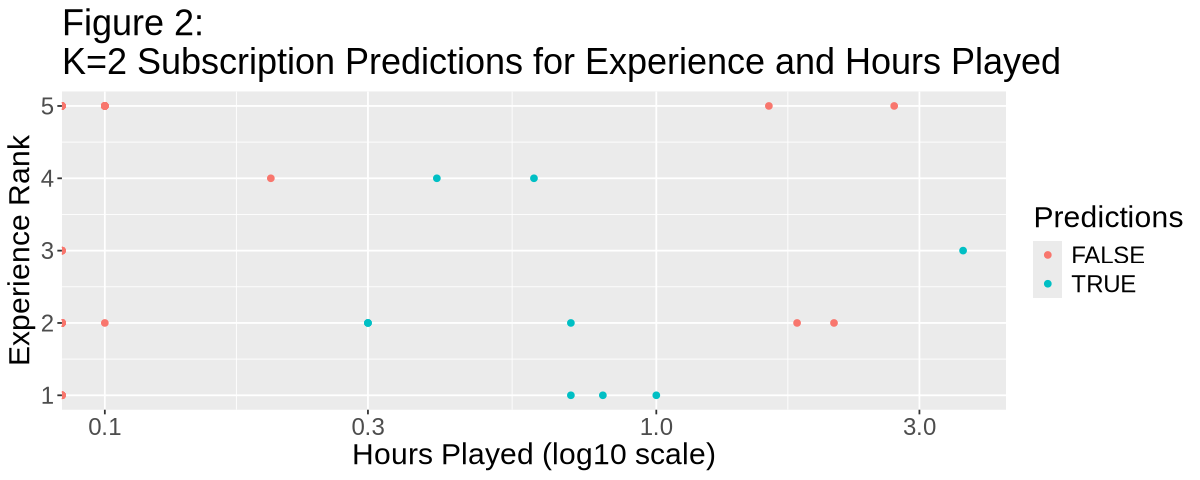

In [11]:
set.seed(12)
options(repr.plot.width = 10, repr.plot.height = 4)
k_2_preds <- predictions_2 |>
    ggplot(aes(x = played_hours, y = experience, color = .pred_class)) +
    geom_point() +
    labs(x = "Hours Played (log10 scale)", y = "Experience Rank", color = "Predictions", title = "Figure 2:\nK=2 Subscription Predictions for Experience and Hours Played") +
    scale_x_log10() +
    theme(text = element_text(size = 18))
k_2_preds

**Figure 2:** On a logarithmic scale, this graph shows each observation in the testing dataset with our subscription predictions coloured.

In [12]:
set.seed(12)
options(repr.plot.width = 10, repr.plot.height = 4)

k_reals_plotted <- players_testing |>
    ggplot(aes(x = played_hours, y = experience, color = subscribe)) +
    geom_point() +
    labs(x = "Hours Played (log10 scale)", y = "Experience Rank", color = "Subscribed?", title = "Figure 3:\nSubscription Status on an Hours Played over Experience Graph") +
    scale_x_log10() +
    theme(text = element_text(size = 18))
k_2_real

ERROR: Error in eval(expr, envir, enclos): object 'k_2_real' not found


COMMENTARY ON PLOT 3

In [ ]:
set.seed(12)
options(repr.plot.width = 10, repr.plot.height = 4)

k_falses_plotted <- players_testing |>
    filter(subscribe == "FALSE") |>
    ggplot(aes(x = played_hours, y = experience, color = subscribe)) +
    geom_point() +
    labs(x = "Hours Played (log10 scale)", y = "Experience Rank", color = "Non-Subscribers", title = "Figure 4:\nNon-Subscribers on an Hours Played over Experience Graph") +
    scale_x_log10() +
    theme(text = element_text(size = 18))
k_falses_plotted

#### COMMENTARY ON FIGURE 4

In [ ]:
set.seed(12)
options(repr.plot.width = 10, repr.plot.height = 4)

precision_plot <- ggplot (metrics_df, aes(x = k, y = precision)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Number of Neighbours",
                         y = "Precision (0-1 scale)") +
                    ggtitle ("Precision Vs. Number of Neigbours") +
                    theme(text = element_text(size = 18))
precision_plot   

#### COMMENTARY ON FIG 5

In [ ]:
set.seed(12)
options(repr.plot.width = 10, repr.plot.height = 4)

recall_plot <- ggplot (metrics_df, aes(x = k, y = recall)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Number of Neighbours",
                         y = "Recall (0-1 scale)") +
                    ggtitle ("Recall Vs. Number of Neigbours") +
                    theme(text = element_text(size = 18))
recall_plot

#### COMMENTARY ON FIG 6

**Discussion:**
   
Using a k-nn classification model maximizing for precision, we obtained a model with an optimal k (2 nearest neighbours) and 79% precision value. After splitting the data, we first created a cross-validation k-tuning model to evaluate accuracy with k. Not only was this model redundant, as it was most accurate when we predicted "TRUE" for every single observation, but it also failed to capture the important aspects of the inquiry question. We figured developpers would be most interested in non-subscribers, so they could figure out why people are not subscribing and offer subscribtion incentives that would cater to non-subscribers in efforts to get as many people subscribed as possible. Thus, we felt it made sense for our model to sophistocatedly predict which people were not subscribed, and we chose precision as the primary metric we would optimize for. **A high precision ensures that when the model predicts someone as a non-subscriber, it is likely correct, minimizing misclassification.** After trying multiple ks, we produced precision and recall values in a data frame and selected the k with the highest precision. **Although precision was our primary metric, we monitored recall to ensure the model was not overly conservative. The recall remained within a reasonable range, suggesting a balanced performance.**  

**While we have obtained some useful findings, we have also identified user behavioral issues that cannot be fully explained by the existing data and deserve further research.** A result of 79% is reasonable, and roughly what we could expect since our classes were so imbalanced. Considering it is significantly more than 50%, this data is useful to the developpers, as they can successfully predict 4 of 5 non-subscribers based on how much they've played and use that data to learn about which people do not subscribe. From our first visualization (our predictions mapped), we see that the biggest cluster of predicted non-subscribers were those who had played very few hours in PlaiCraft, regardless of MineCraft experience. This is a reasonable assumption to make; those who have invested very little of their time into this project are least likely to subscribe, irrespective of their passion for MineCraft. **While `played_hours` was the most predictive feature, we also included variable `experience`. `experience` contributed marginally to the model’s performance but was not the primary driver of prediction accuracy.** What is more interesting, however, is the second cluster of non-subscribers at the high end of hours played in PlaiCraft. For these players, there is no reason why they should not have subscribed, and further efforts to figure out why they have not subscribed would make for impactful marketing research. This is likely the biggest impact of our model; we've predicted a cluster of high-commitment non-subscribers, and this logical discrepancy demands more research. Perhaps there are other factors at play; maybe these players are very young and won't receive emails, or perhaps their hours count is unusually high because they leave the game on in the background. These hypotheses could lead to new data analysis that seeks to unpack exclusively that cluster and explain it. **This model can be integrated into user engagement strategies, flagging high-risk non-subscribers early and allowing targeted incentives or follow-up communications.**  

Finally, although our results lead to some interesting questions, they are hampered by the size and content of the data available. We only have 196 observations with 7 metrics being tracked, leading to a small and thus perhaps more inaccurate testing set. We also can't perform analysis on metrics like "How often do they check their email" or "How many other newsletters are they subscribed to," which means our results must be produced strictly by what we have accessible. Although our model is clearly functional, 79% is not overly powerful, and indeed, the cluster of high-commitment non-subscribers contains two fewer observations than our model suggests. While it is worth investigating, we need more data and a better model before we can pursue other questions related exclusively to that cluster.  
**In summation, here are a few ways to improve the performance of our model:**  
1. **Richer behavioral data** <br>
   Examples: Past subscription behavior in similar games, device type or platform, in-game purchase history...  
2. **Demographic information** <br>
   Examples: Language spoken  
3. **Larger and more diverse dataset** <br> 
The current dataset contains only 196 observations, which may limit the generalizability and reliability of our findings. Future efforts may focus on inviting more players to PlaiCraft or collecting data over a longer period of time. Larger datasets allow for more accurate modeling, better cross-validation, and may reveal patterns not visible in small samples.